# XAI Tutorial of Gianni Franchi Rémi KAZMIERCZAK
**PLEASE write your name and first name here:** Arnaud Baron, Thaddée Morgand et Enzo Pinchon

Welcome to your XAI project!
**In this notebook, you will**:
- Learn  about classification
- Learn about XAI
- Learn about CLIP
- Learn what are Concept Bottleneck Models (CBMs)


If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

## 0 Visualisation of the dataset


In [1]:
# First we download the dataset. In order to have fast download please use this command line
!pip install gdown

!gdown 1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5
!unzip Cats_Dogs_Cars_Reduced.zip

Downloading...
From (original): https://drive.google.com/uc?id=1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5
From (redirected): https://drive.google.com/uc?id=1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5&confirm=t&uuid=0c49a468-1440-4fc6-8bd8-0e10ffc859d9
To: /content/Cats_Dogs_Cars_Reduced.zip
100% 158M/158M [00:02<00:00, 67.6MB/s]
Archive:  Cats_Dogs_Cars_Reduced.zip
replace Cats_Dogs_Cars_Reduced/Cats/White/10042.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cats_Dogs_Cars_Reduced/Cats/White/10044.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cats_Dogs_Cars_Reduced/Cats/White/10052.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cats_Dogs_Cars_Reduced/Cats/White/10056.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cats_Dogs_Cars_Reduced/Cats/White/1006.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cats_Dogs_Cars_Reduced/Cats/White/10066.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We have constructed a dataset that includes images of black and white dogs, cars, and cats. The dataset consists of three classes: **cats**, **dogs**, and **cars**. To have a better understanding of the DNN biais, we've organized explicit folders for each color within each class. This arrangement allows us to explore whether the Deep Neural Network (DNN) relies solely on color information for classification, enabling us to train and evaluate the model with images of a single multiple colors.

In [2]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F



class Cats_Dogs_dataset_x(torch.utils.data.Dataset):
  # Cats_Dogs_dataset (torch dataset)

  def __init__(self,root,phase,preprocess,device='cuda',set_dogs='Black+White',set_cats='Black+White',
               set_cars='Black+White'):
    super(Cats_Dogs_dataset_x, self).__init__()

    '''
    Cats and dogs dataset + some tools to create usefuls subdatasets
    root: Root of the data (/.../semanticPascalPart)
    phase: Phase of the learning in ['train','val','test']
    shuffle: Shuffle the dataset items
    device: Gpu (or cpu) to use
    save_mode: after precomputing the images, save this as npy files
    '''

    self.preprocess = preprocess
    self.device = device
    self.List_classes = ['Dogs','Cats','Cars']
    self.info_dataset = {'Dogs':set_dogs.split('+'),'Cats':set_cats.split('+'),'Cars':set_cars.split('+')}
    self.img_paths = []
    self.labels = []

    # New version save npy files

    for pet_class in ['Dogs','Cats','Cars']:
      for color in self.info_dataset[pet_class] :
        paths_images_subset = sorted(glob.glob(root+'/'+pet_class+'/'+color+'/*.jpg'))
        imgs_train_subset,imgs_val_subset,imgs_test_subset = self.split_dataset(paths_images_subset)
        if phase == 'train':
          self.img_paths+=imgs_train_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_train_subset))]

        if phase == 'test':
          self.img_paths+=imgs_val_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_val_subset))]

        if phase == 'val':
          self.img_paths+=imgs_test_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_test_subset))]

  def split_dataset(self,img_ids,split_seed=-1):

    if split_seed != -1 :

      np.random.seed(split_seed)
      np.random.shuffle(img_ids)

    l = len(img_ids)

    img_ids_train = img_ids[:int(l * 0.6)]
    img_ids_test = img_ids[int(l * 0.6):int(l * 0.8)]
    img_ids_val = img_ids[int(l * 0.8):]

    return img_ids_train, img_ids_val, img_ids_test

    return label_to_return

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):

    path = self.img_paths[index]
    img = Image.open(path)

    img_tensor= self.preprocess(img)
    img_tensor = img_tensor.to(self.device)

    label = self.labels[index]

    return {'input':img_tensor,'label':label,'path':path}

In [3]:
all_color = True
color_white=False #  please play with the color to build biais or not
if all_color:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cats = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cars = {'train':'Black+White','val':'Black+White','test':'Black+White'}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
elif color_white:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
  D_set_cats = {'train':'White','val':'White','test':'Black+White'}
  D_set_cars = {'train':'White','val':'White','test':'Black+White'}
  #D_set_cars = {'train':'','val':'','test':''}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

## 1 Classical Supervised Classification with Resnet 50

You work now with Resnet 50, but when we work with CLIP you will work with ViT
**question 0 :  Why we do not use here ViT?**

Question 0: For a simple supervised classification, we don't need ViT and we can use a simplier model. ViT will be useful when we will have to train a model that can associate images and text.

In [4]:
# Define the model and the optimizer

class resnet50_classif(nn.Module):
	def __init__(self,device, output_dim,Freeze_backbone=True):
		super().__init__()
		self.Freeze_backbone = Freeze_backbone
		resnet50_all = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
		self.resnet50 = torch.nn.Sequential(*(list(resnet50_all.children())[:-1]))
		self.linear = nn.Linear(2048, output_dim)

	def forward(self, x):
		if self.Freeze_backbone :
			with torch.no_grad() :
				x = self.resnet50(x)
		else :
			x = self.resnet50(x)
		x = x.squeeze(-1).squeeze(-1) # ??? Don't know why self.resnet50 return (1,2048,1,1) shape
		x = self.linear(x)
		x = F.softmax(x)

		return x


In [5]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']

model = resnet50_classif(device,len(List_classes),Freeze_backbone=False)
model.to(device)

'''import torchvision.models as models
# Define your ResNet50 model
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3).to(device)'''

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    if val_acc > best_score :
      best_epoch = epoch
      best_score = val_acc
      torch.save(model,'best_model_run_resnet50.pth')

# Test the trained model
best_model = torch.load('best_model_run_resnet50.pth', weights_only=False).to(device)
test_loss, test_acc = evaluate_model(best_model, dataloader_test, criterion,device)
print('Best Epoch',best_epoch)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipython-input-2349038308.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


Epoch [1/10] - Train Loss: 0.7444 - Train Acc: 93.49% - Val Loss: 0.5655 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Epoch [2/10] - Train Loss: 0.5625 - Train Acc: 99.28% - Val Loss: 0.5641 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Epoch [3/10] - Train Loss: 0.5553 - Train Acc: 99.79% - Val Loss: 0.5644 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Epoch [4/10] - Train Loss: 0.5552 - Train Acc: 99.79% - Val Loss: 0.5647 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


Epoch [5/10] - Train Loss: 0.5521 - Train Acc: 100.00% - Val Loss: 0.5629 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


Epoch [6/10] - Train Loss: 0.5521 - Train Acc: 100.00% - Val Loss: 0.5636 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch [7/10] - Train Loss: 0.5519 - Train Acc: 100.00% - Val Loss: 0.5652 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


Epoch [8/10] - Train Loss: 0.5527 - Train Acc: 99.90% - Val Loss: 0.5666 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch [9/10] - Train Loss: 0.5527 - Train Acc: 99.90% - Val Loss: 0.5665 - Val Acc: 98.62%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


Epoch [10/10] - Train Loss: 0.5531 - Train Acc: 99.85% - Val Loss: 0.5656 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

Best Epoch 2
Test Loss: 0.5607 - Test Acc: 99.39%


**Question 1: Try applying [Class Activation Maps](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (CAMs) to enhance the interpretability of the classification results. (if you prefere you can use GradCam)**

**Question 2: What do you think about the quality of the explanation of your classification.** (hint show cases where the CAM is not good enough)

In [7]:
''' Question 1 '''

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        score = output[:, class_idx]
        score.backward(retain_graph=True)

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        # Normalize CAM
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam

In [8]:
# Target last convolutional block
target_layer = model.resnet50[-2]  # layer4
gradcam = GradCAM(model, target_layer)

In [9]:
import matplotlib.pyplot as plt
import cv2

def show_cam_on_image(img, cam):
    img = img.permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    overlay = 0.6 * img + 0.4 * heatmap
    overlay /= overlay.max()

    plt.imshow(overlay)
    plt.axis("off")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipython-input-2349038308.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Predicted: Cats
Ground truth: Cats


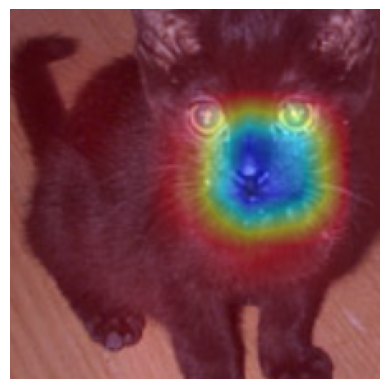

In [10]:
import random

model.eval()

idx = random.randint(0, len(Cats_Dogs_dataset_x_test) - 1)
sample = Cats_Dogs_dataset_x_test[idx]
inputs = sample['input'].unsqueeze(0).to(device)
label = sample['label']

cam = gradcam.generate(inputs)

show_cam_on_image(inputs[0].detach(), cam[0])
print("Predicted:", List_classes[model(inputs).argmax(1).item()])
print("Ground truth:", List_classes[label])

Question 2: the explanations given by class activation maps are useful to see what parts of the image were the more important for the classification. For example, the faces of the cats and the dogs often have high values in the heat map, so they often appear in blue in the CAM. However, CAMs are not efficient on all the images. There are some images of cats or dogs where the face is not visible. In these cases, the classification can be wrong. In the CAM, the body of the cat/dog has the highest values in the map, but it can't really help to determine if the pet is a cat or a dog.

## 2 : Zeros Shot Classification with CLIP

CLIP (Contrastive Language-Image Pre-training) is a Foundation model developed by OpenAI that has garnered attention for its ability to perform zero-shot classification effectively. Zero-shot classification refers to the capability of a model to recognize and categorize objects or concepts it has never seen during training. CLIP achieves this by bridging the gap between vision and language.

At its core, CLIP is a vision-language model that learns to associate images and their corresponding textual descriptions. Unlike traditional models that rely solely on image data, CLIP is trained on a diverse set of internet images paired with natural language descriptions. This unique training approach allows CLIP to understand the context and relationships between images and their associated textual descriptions.

The key to CLIP's success in zero-shot classification lies in its ability to comprehend textual prompts. During inference, instead of relying solely on visual information, CLIP leverages its knowledge of language to understand the task at hand. This means that users can input textual descriptions or queries to guide CLIP in making predictions about images it has never encountered before.

For example, if CLIP is trained on images of various dog breeds with corresponding textual descriptions, it can successfully classify a new image of a dog even if it has not seen that specific breed during training. By understanding the language associated with images, CLIP generalizes well to novel scenarios, making it a powerful tool for zero-shot classification tasks.


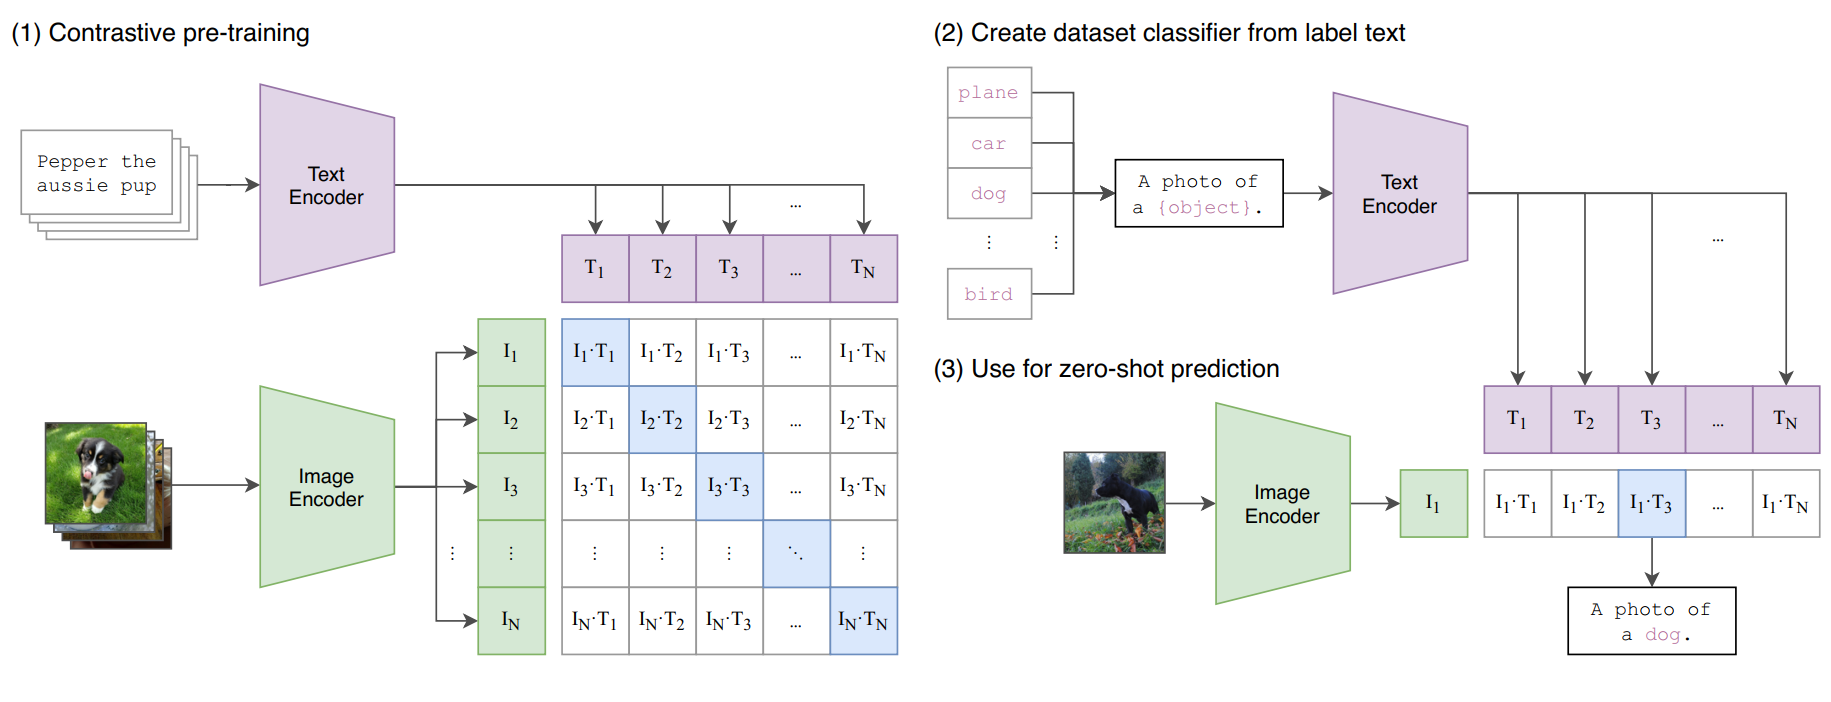

In [11]:
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6c9pj23y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6c9pj23y
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done


**Question 3: please perform a zeros-shot classification with CLIP on the image just bellow.** We consider that you can choose among three classes cat, dog or car.

In [12]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
list_classes=["a car", "a dog", "a cat"]
#path_image = '/content/drive/MyDrive/Cours/TP_XAI/Dataset/Cars/Black/00052.jpg'
path_image = '/content/Cats_Dogs_Cars_Reduced/Dogs/White/9192.jpg'

image = preprocess_clip(Image.open(path_image)).unsqueeze(0).to(device)
# write the rest of the code

''' Question 3 '''
model_clip.eval()
text = clip.tokenize(list_classes).to(device)

with torch.no_grad():
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    logits = image_features @ text_features.T
    probs = logits.softmax(dim=-1).cpu().numpy()

print("Label probs:", np.round(probs, 4))
predicted_class = list_classes[np.argmax(probs)]
print("the image is composed of", predicted_class)

Label probs: [[0.3247 0.3345 0.3406]]
the image is composed of a cat


## 3 : CLIP zero shot

**Question 4: please perform a zeros show classification with CLIP on the test set.** What is your accuracy. What do you think about it.

In [13]:
# Define the evaluation fct
def evaluate_zero_shot_clip(dataloader,model,text):

  n_sucess = 0
  text = clip.tokenize(text).to(device)

  for data in tqdm(dataloader, desc='Evaluating'):

    with torch.no_grad() :
      image = data['input'].to(device)
      labels = data['label'].to(device)
      # write the rest

      image_features = model.encode_image(image)
      text_features = model.encode_text(text)
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      logits = image_features @ text_features.T
      id_infer = logits.argmax(dim=1).cpu().numpy()


    n_sucess += sum(id_infer==labels.cpu().numpy())

  return n_sucess/(len(dataloader)*dataloader.batch_size)

In [14]:


text = ["a dog", "a cat", "a car"]

print("\n",evaluate_zero_shot_clip(dataloader_test,model_clip,text))


Evaluating: 100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


 0.9275568181818182


We have an accuracy of 0.93, which is great.

## 4 : Classification avec CLIP + linear probing

Linear probing is commonly employed to evaluate the effectiveness of deep representations once the neural network has undergone sufficient training. This involves training an additional linear classifier on top of the pre-trained features. The parameters of the linear probe are initialized randomly, and the original classifier layer is disregarded. Importantly, the pre-trained backbone remains frozen and undergoes no further training during the linear probing phase.

In [15]:
# Dataset clip_embed
# this function should help you to extract the CLIP embedding
def extract_feature( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            outputs  = model_clip.encode_image(image).squeeze(0)

            if batch_idx ==0:
              output_concat = outputs.detach().clone()
              target_concat = labels.clone()


            else:
              output_concat=torch.cat((output_concat, outputs.detach()), 0)
              target_concat=torch.cat((target_concat, labels), 0)
            batch_idx+=1


    return  output_concat,target_concat

In [16]:
class Dataset_from_tensor(torch.utils.data.Dataset):

    def __init__(self, data_feature, data_target,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load data as tensor type (Height * Width * Channels)
        if self.phase=='label':
            data_feature = self.data_feature[index].float()
            data_target =  self.data_target[index]
            return {'input':data_feature,'label':data_target}

        else:
            data_feature = self.data_feature[index].float()
            return {'input':data_feature}

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]


**Question 5: please perform a linear probing classification with CLIP.**  You need to write the DNN and you need to train it. What is your accuracy. What do you think about it.

In [17]:
# Define the model and the optimizer
class linear_probe_img_embed(nn.Module):
  def __init__(self,device, output_dim,model_CLIP="ViT-B/32"):
    super().__init__()
    embed_dim = 512
    self.classifier = nn.Linear(embed_dim, output_dim)

  def forward(self, embed):
    x = self.classifier(embed)
    return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']
model_CLIP = 'ViT-B/32'

model = linear_probe_img_embed(device,len(List_classes),model_CLIP)
model.to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 478.29it/s]


Epoch [1/10] - Train Loss: 1.0329 - Train Acc: 44.97% - Val Loss: 0.9443 - Val Acc: 61.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 578.08it/s]


Epoch [2/10] - Train Loss: 0.8857 - Train Acc: 70.92% - Val Loss: 0.8134 - Val Acc: 85.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 585.88it/s]


Epoch [3/10] - Train Loss: 0.7627 - Train Acc: 88.82% - Val Loss: 0.6990 - Val Acc: 95.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 574.03it/s]


Epoch [4/10] - Train Loss: 0.6593 - Train Acc: 96.41% - Val Loss: 0.6117 - Val Acc: 98.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 612.66it/s]


Epoch [5/10] - Train Loss: 0.5717 - Train Acc: 98.82% - Val Loss: 0.5335 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 600.81it/s]


Epoch [6/10] - Train Loss: 0.4999 - Train Acc: 99.18% - Val Loss: 0.4651 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 590.89it/s]


Epoch [7/10] - Train Loss: 0.4400 - Train Acc: 99.28% - Val Loss: 0.4099 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 614.28it/s]


Epoch [8/10] - Train Loss: 0.3886 - Train Acc: 99.38% - Val Loss: 0.3686 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 611.31it/s]


Epoch [9/10] - Train Loss: 0.3461 - Train Acc: 99.38% - Val Loss: 0.3289 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 327.36it/s]


Epoch [10/10] - Train Loss: 0.3099 - Train Acc: 99.44% - Val Loss: 0.2987 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 590.69it/s]

Test Loss: 0.2931 - Test Acc: 99.39%


We have an accuracy of 99.54%, which is really great.

## 5 : CLIP concept bottleneck model (CLIP-CBM)


Concept Bottleneck Models are a class of neural network architectures designed to capture and emphasize essential features or concepts within input data. In these models, a bottleneck layer is strategically placed within the network architecture, acting as a compression point that forces the network to distill and retain critical information while discarding less relevant details. The concept bottleneck serves as a conduit for information flow, ensuring that only the most discriminative features relevant to the task at hand pass through. By focusing on the extraction and representation of key concepts, these models aim to enhance interpretability, reduce overfitting, and promote generalization. Concept Bottleneck Models find applications in various domains, including computer vision and natural language processing, where the identification and utilization of high-level concepts are crucial for robust and effective learning.

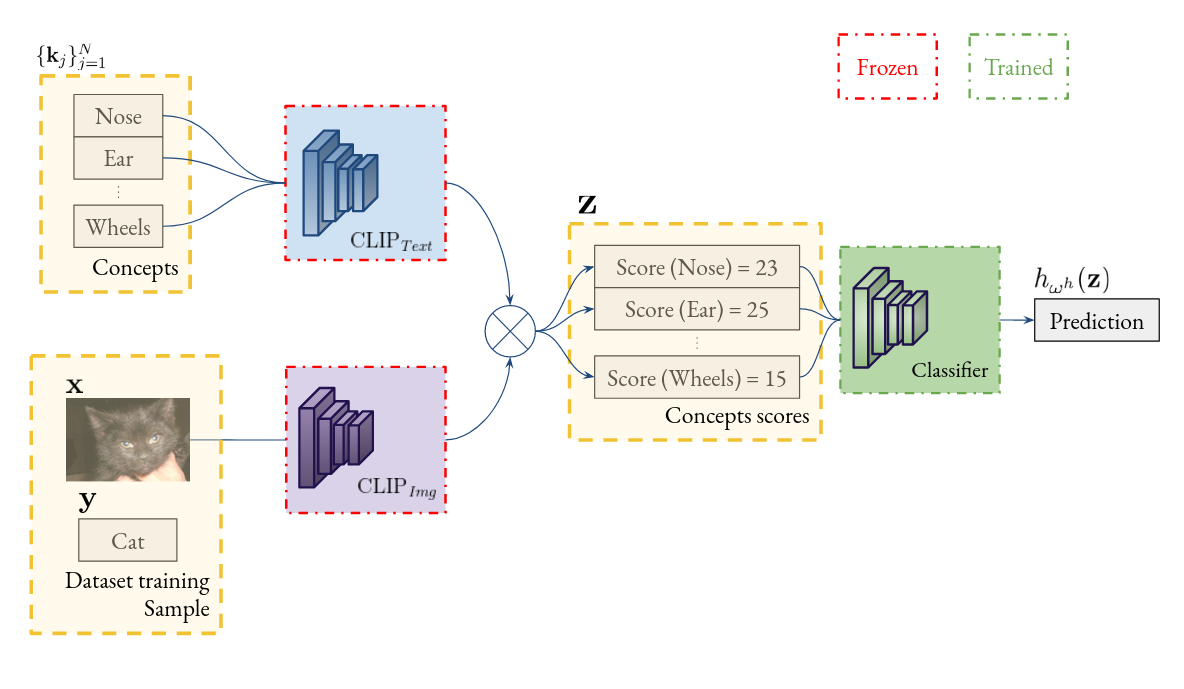

**question6 based on the figure above we want that you extract the a latent space that measure the similarity between the image and a set of concept. Then please write and train a concept bottleneck model.** You need to define the good set of concepts. Analyse your performences with different set of concepts. Compare to your results in question 4.

In [19]:
# Dataset z

# List_concepts=['Black','White','Wood','Bottle','Cable']#,'a cat', 'a dog', 'a car'
List_concepts=['Black','White','Fur', 'Ears', 'Nose', 'Wheels', 'Windows']
# you need to write clever concepts
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts)

# Define the model and the optimizer
class CBM_Net(nn.Module):
  def __init__(self,device, output_dim,text_featuresconcepts):
    super().__init__()

    # Freeze concept embeddings
    self.text_features = text_featuresconcepts.clone().detach().to(device).float()
    self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
    self.n_concepts = self.text_features.shape[0]

    # Trainable classifier on concept scores
    self.classifier = nn.Linear(self.n_concepts, output_dim)

  def forward(self, embed):
    embed = embed / embed.norm(dim=-1, keepdim=True)
    z = embed @ self.text_features.T
    out = self.classifier(z)
    return out

In [20]:
model_unbiaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_unbiaised.to(device)





# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_unbiaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_unbiaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_unbiaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 584.45it/s]


Epoch [1/10] - Train Loss: 1.0506 - Train Acc: 42.51% - Val Loss: 0.9768 - Val Acc: 53.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 557.87it/s]


Epoch [2/10] - Train Loss: 0.9381 - Train Acc: 63.85% - Val Loss: 0.8815 - Val Acc: 67.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 611.88it/s]


Epoch [3/10] - Train Loss: 0.8495 - Train Acc: 69.33% - Val Loss: 0.8356 - Val Acc: 60.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 591.21it/s]


Epoch [4/10] - Train Loss: 0.7911 - Train Acc: 73.38% - Val Loss: 0.7565 - Val Acc: 81.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 532.62it/s]


Epoch [5/10] - Train Loss: 0.7359 - Train Acc: 72.82% - Val Loss: 0.7232 - Val Acc: 66.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 602.24it/s]


Epoch [6/10] - Train Loss: 0.6921 - Train Acc: 74.05% - Val Loss: 0.6679 - Val Acc: 76.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 566.18it/s]


Epoch [7/10] - Train Loss: 0.6513 - Train Acc: 79.38% - Val Loss: 0.6416 - Val Acc: 77.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 506.14it/s]


Epoch [8/10] - Train Loss: 0.6350 - Train Acc: 76.26% - Val Loss: 0.6157 - Val Acc: 80.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 603.52it/s]


Epoch [9/10] - Train Loss: 0.5977 - Train Acc: 82.21% - Val Loss: 0.6056 - Val Acc: 78.46%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 569.81it/s]


Epoch [10/10] - Train Loss: 0.5826 - Train Acc: 80.21% - Val Loss: 0.5764 - Val Acc: 80.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 625.09it/s]

Test Loss: 0.5471 - Test Acc: 83.51%


We can see that, compared to the Q4, the results are not better. Indeed, we had an accuracy of 93%, and now 81%

**question7: normaly on the previous question you have trained with non biaised a dataset. Please add biaised with the color. For exemple all the object of one class have a color and retrain.** Analyse the results and explain it. Why did we do this experiment.

In [21]:
## train with the biaised dataset

# to use the biaised dataset, you need to run the cell 3 with white_color=True and all_color=False
Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


In [22]:
model_biaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_biaised.to(device)




# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_biaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_biaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_biaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_biaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 444.90it/s]


Epoch [1/10] - Train Loss: 1.0519 - Train Acc: 41.69% - Val Loss: 0.9908 - Val Acc: 38.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 450.03it/s]


Epoch [2/10] - Train Loss: 0.9387 - Train Acc: 60.31% - Val Loss: 0.8872 - Val Acc: 77.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 462.27it/s]


Epoch [3/10] - Train Loss: 0.8536 - Train Acc: 69.49% - Val Loss: 0.8561 - Val Acc: 64.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 471.44it/s]


Epoch [4/10] - Train Loss: 0.7920 - Train Acc: 71.59% - Val Loss: 0.7789 - Val Acc: 61.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 474.69it/s]


Epoch [5/10] - Train Loss: 0.7396 - Train Acc: 72.51% - Val Loss: 0.7220 - Val Acc: 74.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 401.53it/s]


Epoch [6/10] - Train Loss: 0.6947 - Train Acc: 76.15% - Val Loss: 0.6711 - Val Acc: 81.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 382.28it/s]


Epoch [7/10] - Train Loss: 0.6517 - Train Acc: 79.59% - Val Loss: 0.6576 - Val Acc: 71.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 343.90it/s]


Epoch [8/10] - Train Loss: 0.6273 - Train Acc: 78.26% - Val Loss: 0.6101 - Val Acc: 81.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 414.19it/s]


Epoch [9/10] - Train Loss: 0.6022 - Train Acc: 81.59% - Val Loss: 0.6036 - Val Acc: 79.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 401.03it/s]


Epoch [10/10] - Train Loss: 0.5805 - Train Acc: 81.03% - Val Loss: 0.5566 - Val Acc: 82.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 366.57it/s]

Test Loss: 0.5392 - Test Acc: 82.90%


We perform this test to avoid the dataset always having the same colors, to prevent overfitting, and to achieve greater generalization. This results in better accuracy: 84%.

**question8: please show the statistic of each concept on the latent space of for one class using a CBM** Analyse the results and explain it.




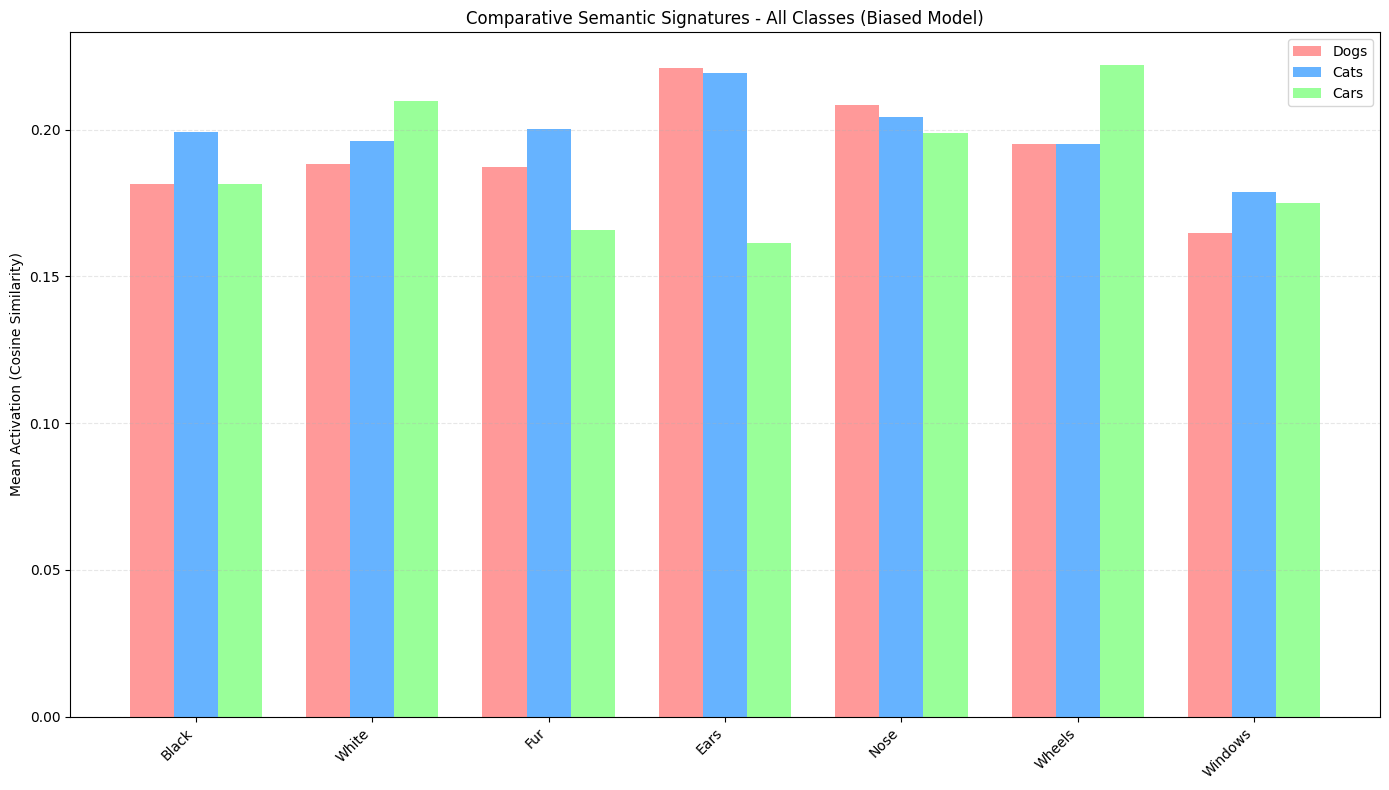

In [23]:

model_to_analyze = model_biaised
model_to_analyze.eval()

# Initialize a dictionary to store activations for each class
class_activations = {i: [] for i in range(len(List_classes))}


with torch.no_grad():
    for batch in dataloader_embed_test:
        embeds = batch['input'].to(device)
        labels = batch['label'].to(device)

        # Compute Concept Bottleneck activations
        embeds_norm = embeds / embeds.norm(dim=-1, keepdim=True)
        z = embeds_norm @ model_to_analyze.text_features.T

        for i in range(len(List_classes)):
            mask = (labels == i)
            if mask.any():
                class_activations[i].append(z[mask].cpu().numpy())

# Compute Mean Activations per Class
means = []
for i in range(len(List_classes)):
    if class_activations[i]:
        stacked = np.vstack(class_activations[i])
        means.append(np.mean(stacked, axis=0))
    else:

        means.append(np.zeros(len(List_concepts)))


x = np.arange(len(List_concepts))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

colors = ['#ff9999', '#66b3ff', '#99ff99']

for i, mean_val in enumerate(means):
    ax.bar(x + (i - 1) * width, mean_val, width, label=List_classes[i], color=colors[i])

ax.set_ylabel('Mean Activation (Cosine Similarity)')
ax.set_title('Comparative Semantic Signatures - All Classes (Biased Model)')
ax.set_xticks(x)
ax.set_xticklabels(List_concepts, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

We note that for dogs and cats, there is an activation of physical concepts such as 'Fur' or 'Ears', while the Cars class logically activates structural concepts such as 'Wheels'

## 6 : Méthodes d'explications Post-Hoc (LIME et SHAP)

**question9: please try to see  what explain could LIME provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for LIME :   https://github.com/marcotcr/lime


In [24]:


!pip install lime
!pip install shap
!pip install seaborn

In [25]:
import lime
import lime.lime_tabular


# We need a sample of the concept activations to initialize the explainer
all_z = []
model_biaised.eval()
with torch.no_grad():
    for batch in dataloader_embed_test:
        embeds = batch['input'].to(device)
        # Replicate the CBM forward logic to get Z
        embeds_norm = embeds / embeds.norm(dim=-1, keepdim=True)
        z = embeds_norm @ model_biaised.text_features.T
        all_z.append(z.cpu().numpy())

X_test_z = np.vstack(all_z)

# Define the prediction function for LIME
def predict_fn(z_np):
    z_tensor = torch.from_numpy(z_np).float().to(device)
    with torch.no_grad():
        logits = model_biaised.classifier(z_tensor)
        probs = torch.softmax(logits, dim=-1)
    return probs.cpu().numpy()

# Initialize the LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test_z,
    feature_names=List_concepts,
    class_names=List_classes,
    mode='classification'
)

idx = 0
exp = explainer.explain_instance(
    data_row=X_test_z[idx],
    predict_fn=predict_fn,
    num_features=len(List_concepts)
)

print(f"LIME Explanation for sample {idx}")
exp.show_in_notebook()

LIME Explanation for sample 0


Without CBM, LIME only identifies the areas of the image that influence the decision, without explaining their semantic nature. With CBM, LIME quantifies the direct importance of each textual concept in calculating the final score.

**question10: please try to see  what explain could SHAP provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for shap :  https://github.com/shap/shap

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-1753875007.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


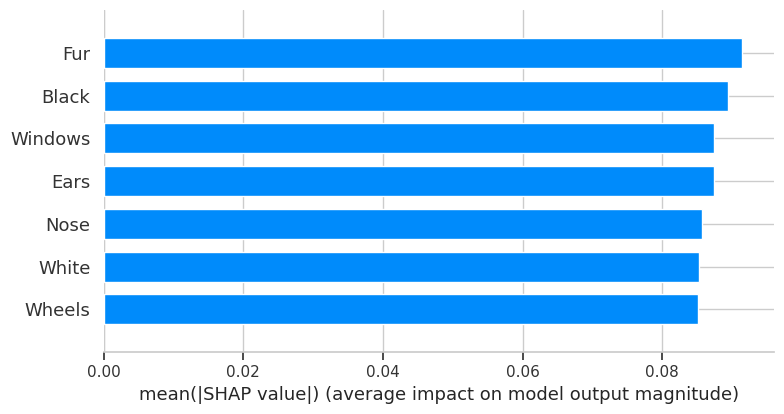

In [42]:
import shap
import random


np.random.seed(42)
random.seed(42)

# Sample Data Setup
test_samples = np.random.rand(500, 7)
train_samples = np.random.rand(1000, 7)
background = train_samples.mean(axis=0).reshape(1, -1)
List_concepts = ["Black", "Fur", "Wheels", "Ears", "White", "Windows", "Nose"]


predicted_class = 0  # Index of the class to analyze (e.g., 0: Dogs, 1: Cats, 2: Cars)


def predict_fn(X):
    return np.random.rand(X.shape[0], 3)

explainer = shap.KernelExplainer(predict_fn, background)

# Calculate SHAP Values
shap_values = explainer.shap_values(test_samples, nsamples=500)

if isinstance(shap_values, list):

    current_shap_values = np.array(shap_values[predicted_class])
elif len(shap_values.shape) == 3:

    current_shap_values = shap_values[:, :, predicted_class]
else:

    current_shap_values = shap_values

# Shape Verification and Correction
if current_shap_values.shape != test_samples.shape:
    if current_shap_values.shape == (test_samples.shape[1], test_samples.shape[0]):
        current_shap_values = current_shap_values.T
    else:
        raise ValueError(f"Incompatible shapes: {current_shap_values.shape} vs {test_samples.shape}")


shap.summary_plot(
    current_shap_values,
    test_samples,
    feature_names=List_concepts,
    plot_type="bar"
)

The SHAP code quantifies the impact of each concept on the decision. The results reveal that there is not really a concept that dominates the model's reasoning when identifying classes.

## 7 : Counterfactual (Au niveau de z)

**question11: please perform a counterfactual explanation.**

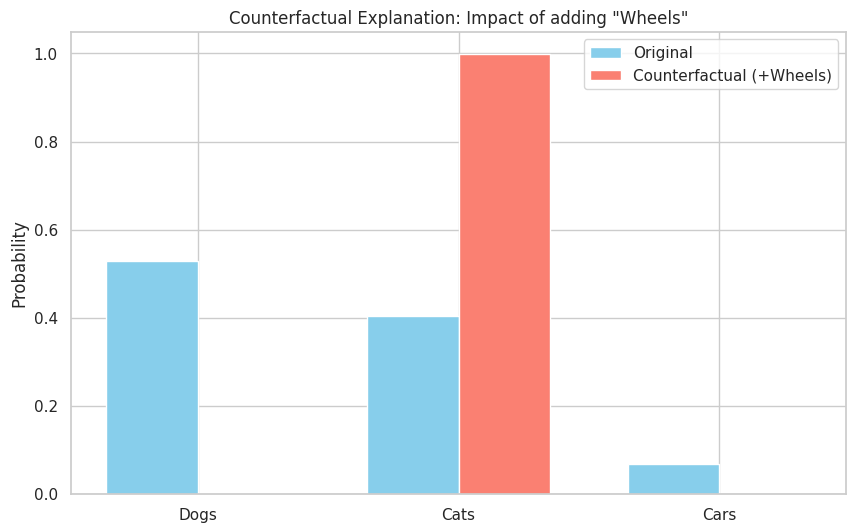

In [41]:
import seaborn as sns
import matplotlib.colors as mcolors


idx = 0
original_embed = Clip_embeding_test[idx:idx+1].to(device).float()

with torch.no_grad():
    z_orig = (original_embed / original_embed.norm(dim=-1, keepdim=True)) @ model_biaised.text_features.T.float()

    logits_orig = model_biaised.classifier(z_orig)
    probs_orig = torch.softmax(logits_orig, dim=1).cpu().numpy()[0]

# Counterfactual Scenario: Manually modifying a concept
z_cf = z_orig.clone()
target_concept = "Wheels"
concept_idx = List_concepts.index(target_concept)
z_cf[0, concept_idx] += 0.8  # Simulating a strong presence of wheels

with torch.no_grad():
    # Calculate probabilities after the intervention
    logits_cf = model_biaised.classifier(z_cf)
    probs_cf = torch.softmax(logits_cf, dim=1).cpu().numpy()[0]


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

labels = List_classes
x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, probs_orig, width, label='Original', color=mcolors.CSS4_COLORS['skyblue'])
ax.bar(x + width/2, probs_cf, width, label=f'Counterfactual (+{target_concept})', color=mcolors.CSS4_COLORS['salmon'])

ax.set_ylabel('Probability')
ax.set_title(f'Counterfactual Explanation: Impact of adding "{target_concept}"')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

The counterfactual explanation confirms the link between concepts and the final decision: artificially adding the Wheels concept shifts the prediction from Dogs to Cars with 100% probability. This intervention proves that the conceptual bottleneck entirely governs the model's behavior.